# Neuron decoding

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(42)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

In [2]:
def LIF_a(tau_ref, tau_rc, J):
    A = np.zeros(J.shape)
    for x, j in enumerate(J): 
        A[x] = (tau_ref - (tau_rc*np.log(1-j**(-1))))**(-1) if (j > 1) else 0
    return A

class singleNeuron():
    T = 0
    dt = 0.001
    encoder = 1
    x = np.linspace(0,1,int(1/dt))
    time = 0
    X = 0
    
    # LIF params 
    alpha = 0
    j_bias = 0
    J = 0
    a = 0
    V = 0
    dV = 0
    tau_rc = 0
    tau_ref = 0
    spikes = 0
    a_max = 0
    
    def __init__(self, T, dt, tau_rc, tau_ref, encoder=None, maxFR = None, r=None):
        if encoder: 
            self.encoder = encoder
        else: 
            self.encoder = np.random.choice([-1, 1]) 
        
        # initialize lif neuron params 
        self.T = T
        self.dt = dt
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.time = np.linspace(0, T, int(T/dt))
        if r: 
            self.x = np.linspace(-r, r, int(T/dt))
            self.x_int = np.random.uniform(low=-r, high=r) 
        else: 
            self.x = np.linspace(-1, 1, int(T/dt))
            self.x_int = np.random.uniform(low=-1, high=1) 
        # initialize max firing rate
        if maxFR: 
            self.a_max = maxFR
        else: 
            self.a_max = np.random.uniform(low=100, high=200)
        
        # solve for gain a: 
        demon_p1 = 1 - np.exp((self.a_max*tau_ref - 1)/(self.a_max*tau_rc))
        demon_p2 = 1 - self.x_int
        self.alpha = 1/(demon_p1*demon_p2)
        
        # solve for j_bias 
        self.j_bias = -self.alpha * self.x_int 
        
        # set J 
        self.J = self.calcJ(self.x)
        
        # Calculate the firing rate as a function of current
        self.a = LIF_a(tau_ref, tau_rc, self.J)
    
    def calcJ(self, x):
        J = self.encoder * self.alpha * x + self.j_bias
        return J

    def spikeTrain(self, x):
        n = int(self.T/self.dt)
        
        if isinstance(x, int):
            # if input signal is constant, fill with same value 
            j = np.full([n], self.calcJ(x)) 
        else:
            j = self.calcJ(x) 
        
        # initialize Spikes, Voltage and dV functions
        self.V = np.zeros(n)
        self.spikes = np.zeros(n)
        self.dV = np.zeros(n)
        # Calculate dV and V for each time step 
        for i in range(0,n):
             # calculate dV (change in V) given the previous V 
            self.dV[i] = 1/self.tau_rc * (j[i] - self.V[i]) * self.dt  
            if i < len(self.V)-1: 
                 # calculate next V given dV and previous V
                self.V[i+1] = self.V[i] + self.dV[i]
                # if the next V will be over 1, we spike and set V to 0
                if self.V[i+1] >= 1:                                          
                    self.V[i+1] = 0
                    self.spikes[i] = 1         
        return self.spikes

In [3]:
def get_rms(signal): 
    return np.sqrt(np.sum(signal**2)/len(signal))

def generate_signal(T, dt, rms, limit, seed): 
    np.random.seed(seed)
    
    lenT = int(T/dt)
    t = np.linspace(0, T, lenT)
    dw = (2*np.pi)/T
    fs = np.arange(lenT) / T 
    omega = fs * 2.0 * np.pi
    # generate random signal that is normal distributed in time domain
    # sig = np.random.normal(0, 1, t.shape) # white noise 
    
    #  X(w) 
    positive_omega_size = int(omega.size/2)
    SIG_posw = np.random.normal(0, 1, size=(positive_omega_size,2)).view(np.complex128)
    SIG_negw = SIG_posw.conjugate()
    SIG = np.concatenate([SIG_negw, SIG_posw])[:,0]

    # bandlimit the signal
    freq = fs
    filt = np.piecewise(freq, [freq <= limit, freq>limit], [lambda freq: 1, lambda freq: 0])
    filt[0] = 0
    SIG_filt = SIG*filt
    
    # get time domain signal
    sig_filt = np.fft.ifft(SIG_filt).real
    sig_f = sig_filt * (rms/get_rms(sig_filt))
    
    SIG_f = np.fft.fft(sig_f)
    SIG_f = abs(SIG_f)
    
    return sig_f, SIG_f, omega

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

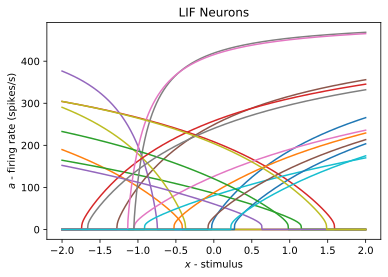

In [4]:
n = 20
tau_ref = 0.002
tau_rc = 0.02
# time param not yet used, just that initialization needed 
T = 1
dt = 0.001 
X = np.linspace(-2, 2, int(T/dt))

A = np.zeros([n,len(X)])
Neurons = [None]*n

np.random.seed(12)
for i in range(0, n):
    neu = singleNeuron(T, dt, tau_rc, tau_ref, r=2)
    Neurons[i] = neu
    A[i] = neu.a
    plt.plot(X, A[i])
plt.xlabel('$x$ - stimulus')
plt.ylabel('$a$ - firing rate (spikes/s)')
plt.title('LIF Neurons');

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

In [5]:
def decoderWithNoise(A, X, sigma_const):
    # find decoder D via least square 
    n, N = A.shape #A is a nxN matrix (n = number to neurons in the population)
    sigma = sigma_const*np.max(A) 
    # regularization 0.5 
    D = np.linalg.lstsq(A@A.T + 0.5*N*np.square(sigma)*np.eye(n), A@X.T, rcond=None)[0].T
    return D

# decoder that accounts noise on regular A -- d) plots
d_decoderWithNoise = decoderWithNoise(A, X, 0.1)
X_decoderWithNoise = d_decoderWithNoise@A

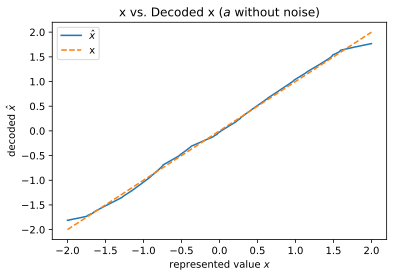

In [6]:
plt.plot(X, X_decoderWithNoise)
plt.plot(X, X, linestyle='dashed')
plt.legend(['$\^{x}$', 'x'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$')
plt.title('x vs. Decoded x ($a$ without noise)');

rmse: 0.057493755412867845


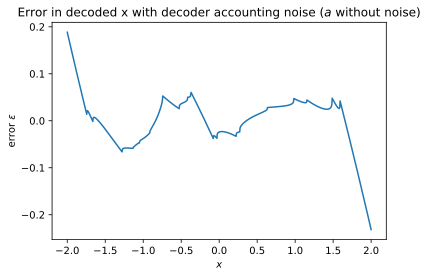

In [7]:
plt.plot(X, X_decoderWithNoise-X)
plt.xlabel('$x$')
plt.ylabel('error $\epsilon$')
plt.title('Error in decoded x with decoder accounting noise ($a$ without noise)');

def calculateRMSE(x, x_pred): 
    return np.sqrt(((x_pred-x) ** 2).mean())

rmse_dNoise_a = calculateRMSE(X, X_decoderWithNoise)
print("rmse: " + str(rmse_dNoise_a))

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

In [8]:
def postSynapticFilter(n, tau, x):
    Nt = x.size
    dt = 0.001
    t = np.arange(Nt) * dt 

    # Create the filter
    h = np.exp(-t/tau) / tau
    
    return h
    
h0 = postSynapticFilter(0, 0.005, X)

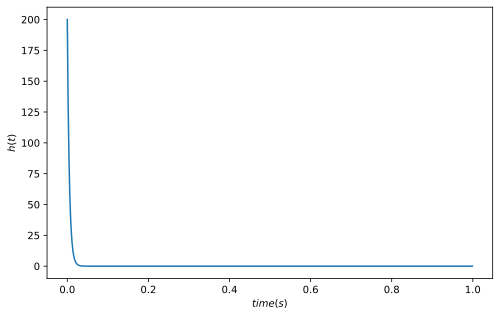

In [9]:
t = np.arange(X.size) * 0.001
plt.figure(figsize = (8,5))
plt.plot(t, h0)
plt.ylabel('$h(t) $');
plt.xlabel('$time (s) $');

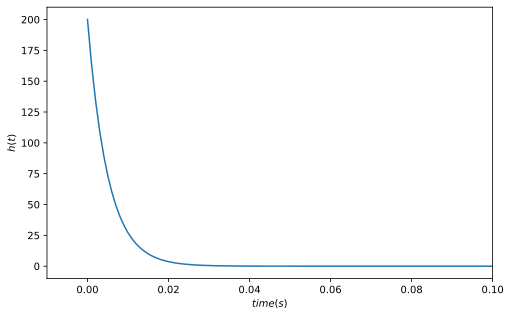

In [10]:
t = np.arange(X.size) * 0.001
plt.figure(figsize = (8,5))
plt.plot(t, h0)
plt.xlim(-0.01, 0.1)
plt.ylabel('$h(t) $');
plt.xlabel('$time (s) $');

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

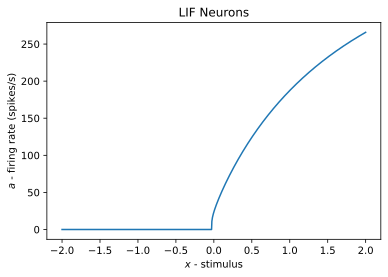

In [11]:
# choose neuron from part 1 that has a firing rate of 20Hz - 50Hz for x = 0
for i in range(A.shape[0]): 
    ## check which has value within 20 - 50 
    ## x[499] and x[500] enclose x=0 (-0.0005 - 0.005)
    if (A[i][499] >= 20 and A[i][499] <= 50) or (A[i][500] >= 20 and A[i][500] <= 50): 
        Ai = A[i]
        Neuron = Neurons[i]
        break
        
plt.plot(Neuron.x, Neuron.a)
plt.xlabel('$x$ - stimulus')
plt.ylabel('$a$ - firing rate (spikes/s)')
plt.title('LIF Neurons');

In [12]:
def get_negative(neu): 
    # initialize a random neuron
    target = singleNeuron(1,0.001,0.002,0.002)
    # set all values same as the input, except for encoder is opposite
    target.T = neu.T
    target.dt = neu.dt
    target.time = neu.time
    target.x = neu.x
    target.tau_rc = neu.tau_rc
    target.tau_ref = neu.tau_ref

    target.a_max = neu.a_max
    target.x_int = neu.x_int
    target.encoder = -neu.encoder

    demon_p1 = 1 - np.exp((target.a_max*neu.tau_ref - 1)/(target.a_max*neu.tau_rc))
    demon_p2 = 1 - neu.x_int
    target.alpha = 1/(demon_p1*demon_p2)
    # solve for j_bias 
    target.j_bias = -target.alpha * target.x_int 
    # set J 
    target.J = target.calcJ(target.x)
    # Calculate the firing rate as a function of current
    target.a = LIF_a(target.tau_ref, target.tau_rc, target.J)
    
    return target

# Neuron Pair Class (extends singleNeuron)
class twoNeurons():
    pos_neu = 0
    neg_neu = 0
    def __init__(self, T, dt, tau_rc, tau_ref, neuron):
        if neuron: 
            if neuron.encoder == 1: 
                self.pos_neu = neuron 
                self.neg_neu = get_negative(neuron)
                
            else: 
                self.neg_neu = neuron 
                self.pos_neu = get_negative(neuron)
        else: 
            self.pos_neu = singleNeuron(T, dt, tau_rc, tau_ref)
            # create the negative encoded single neuron
            self.neg_neu = singleNeuron(T = T, dt = dt, tau_rc = tau_rc, tau_ref = tau_ref, encoder = -self.pos_neu.encoder)
    
    def spikeTrains(self, x):
        return self.pos_neu.spikeTrain(x), self.neg_neu.spikeTrain(x)

In [13]:
# decode function same as last assignment, just changed the identity decoder to decoder with noise
def decodeSpikesPostSynapticFilter(T, dt, tau, x, spikes):
    Nt = x.size
    dt = 0.001
    t = np.arange(Nt) * dt 
    
    # Create the filter 
    h = np.exp(-t/tau) / tau
    
    H = np.fft.rfft(h)
    
    # frequency domain signal 
    SPIKES = [(np.fft.rfft(spikes[0])), (np.fft.rfft(spikes[1]))]
    
    # apply filter on frequency domain signal 
    FSPIKES = [H*SPIKES[0], H*SPIKES[1]]
    spikes_filt = [(np.fft.irfft((FSPIKES[0]))), (np.fft.irfft((FSPIKES[1])))]
    
    A = np.array(spikes_filt)
    
    #decode with decoder accounting noise 
    d = decoderWithNoise(A, x, 0.1)
        
    # Decode the spike train 
    xhat = d@A
    
    return t, h, x, xhat

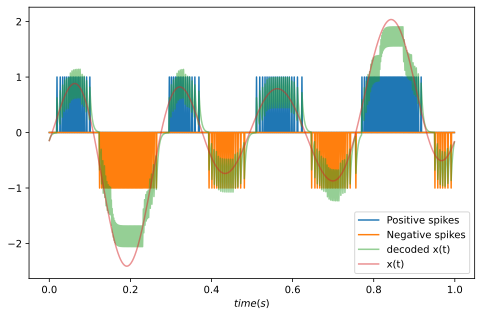

In [14]:
sig5, SIG5, omega = generate_signal(1, 0.001, 1, 5, seed=12)

neupair = twoNeurons(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, neuron=Neuron)
pos_neu, neg_neu = neupair.spikeTrains(x=sig5)

spikes = np.asarray([pos_neu, neg_neu])
t, h, x, xhat = decodeSpikesPostSynapticFilter(1, 0.001, 0.005, sig5, spikes)

plt.figure(figsize = (8,5))
plt.plot(t, pos_neu, label='Positive spikes')
plt.plot(t, -1*neg_neu, label='Negative spikes')
plt.plot(t, xhat, label='decoded x(t)', alpha=0.5)
plt.plot(t, x, label='x(t)', alpha=0.5)
plt.title('')

plt.xlabel('$time (s) $');
plt.legend(loc='best');

**c) Error analysis.** Compute the RMSE of the decoding.

In [15]:
rmse = calculateRMSE(x, xhat)
print("rmse: " + str(rmse))

rmse: 0.26416074722861993


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

In [16]:
def spikesPostSynapticFilter(T, dt, tau, x, spikes):
    Nt = x.size
    dt = 0.001
    t = np.arange(Nt) * dt 
    # Create the filter 
    h = np.exp(-t/tau) / tau
    H = np.fft.rfft(h)
    
    SPIKES = np.fft.rfft(spikes)
    # apply filter on frequency domain signal 
    FSPIKES = H*SPIKES
    spikes_filt = np.fft.irfft(FSPIKES)
    
    return spikes_filt

In [17]:
def generate_rmse_neurons(n): 
    tau_ref = 0.002
    tau_rc = 0.02
    T = 1
    dt = 0.001 
    X = np.linspace(-2, 2, int(T/dt))
    neurons = [None]*n
    A = np.zeros([n,int(T/dt)])

    sig5, SIG5, omega = generate_signal(1, 0.001, 1, 5, seed=np.random.randint(0, 100))
    
    for i in range(0, n):
        neu = singleNeuron(T, dt, tau_rc, tau_ref)
        neurons[i] = neu    
        spikes = neu.spikeTrain(x=sig5)
        spikes_filt = spikesPostSynapticFilter(1, 0.001, 0.005, sig5, spikes)
        A[i] = np.array(spikes_filt)
    
    #decode with decoder accounting noise 
    d = decoderWithNoise(A, sig5, 0.1)
    # Decode the spike train 
    xhat = d@A
    rmse = calculateRMSE(sig5, xhat)
    
    return rmse

In [18]:
group_size = [8, 16, 32, 64, 128, 256]
sample_size = 10
avgRMSE = np.zeros(6)

for i, n in enumerate(group_size): 
    rmse_samples = np.zeros(sample_size)
    for j in range(1, sample_size): 
        rmse_samples[j] = generate_rmse_neurons(n)
    avgRMSE[i] = np.mean(rmse_samples)

Text(0, 0.5, 'RMSE')

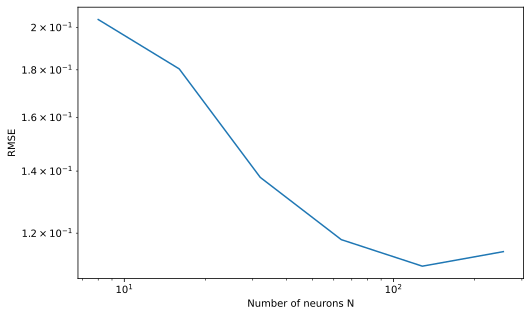

In [19]:
plt.figure(figsize = (8,5))
plt.loglog(group_size, avgRMSE)


plt.xlabel('Number of neurons N');
plt.ylabel('RMSE')

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

As the neuron count increase, the RMSE decreases. The error due to noise is a function of number of neurons, hence it decreases as at a rate proportional to 1/N where N is the number of neurons. 

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

In [20]:
# decoder 1 for f(x) = 2x+1 
def functionDecoder(A, Y, sigma_const): 
    n, N = A.shape
    d = Y.shape[0]
    D = np.linalg.lstsq((A@A.T + N*np.square(sigma_const*np.max(A))*np.eye(n)), A@Y.T, rcond=None)[0].T

    return D

In [21]:
def generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x, seed): 
    A = np.zeros([n,len(x)])
    Neurons = [None]*n
    
    np.random.seed(seed)
    for i in range(0, n):
        neu = singleNeuron(T, dt, tau_rc, tau_ref)
        Neurons[i] = neu
        spikes = neu.spikeTrain(x=x)
        spikes_filt = spikesPostSynapticFilter(T, dt, tau, x, spikes)
        A[i] = np.array(spikes_filt)
    
    return Neurons, A

In [22]:
n = 200
tau_ref = 0.002
tau_rc = 0.02
T = 1
dt = 0.001 
t = np.linspace(0,1, int(1/dt))
tau = 0.005

x1 = t - 1
y1=2*x1+1

# construct population x
Neurons_X, A_X = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x1, 24)

Df = functionDecoder(A_X, y1, 0.1)
x_hat_Df = Df@A_X

# construct population y 
Neurons_Y, A_Y = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x_hat_Df, 205)

D_y = decoderWithNoise(A_Y, x_hat_Df, 0.1)
y_hat = D_y@A_Y

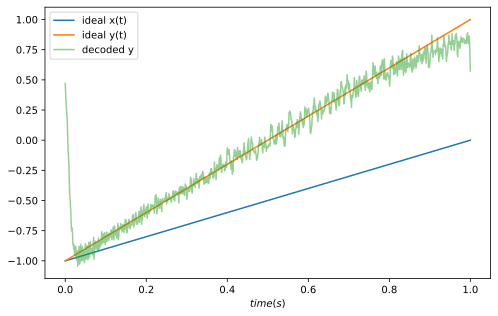

In [23]:
plt.figure(figsize = (8,5))
plt.plot(t, x1, label='ideal x(t)')
plt.plot(t, y1, label='ideal y(t)')
plt.plot(t, y_hat, label='decoded y', alpha=0.5)

plt.xlabel('$time (s) $');
plt.legend(loc='best');

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

In [24]:
x2 = np.zeros(int(T/dt))
for i in range(10): 
    x2[i*int(len(x2)/10):(i+1)*int(len(x2)/10)] = np.random.uniform(-1, 0) 
    
y2 = 2*x2+1

In [25]:
# construct population x
Neurons_X, A_X = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x2, 24)

x_hat_Df = Df@A_X

# construct population y 
Neurons_Y, A_Y = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x_hat_Df, 205)

y_hat = D_y@A_Y

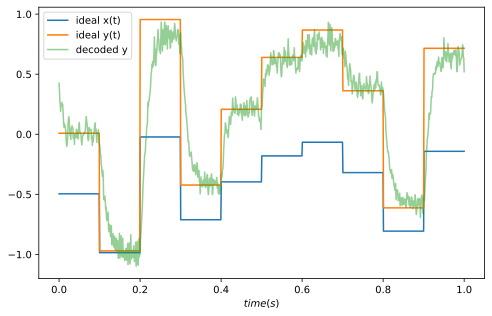

In [26]:
plt.figure(figsize = (8,5))
plt.plot(t, x2, label='ideal x(t)')
plt.plot(t, y2, label='ideal y(t)')
plt.plot(t, y_hat, label='decoded y', alpha=0.5)

plt.title('')

plt.xlabel('$time (s) $');
plt.legend(loc='best');

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

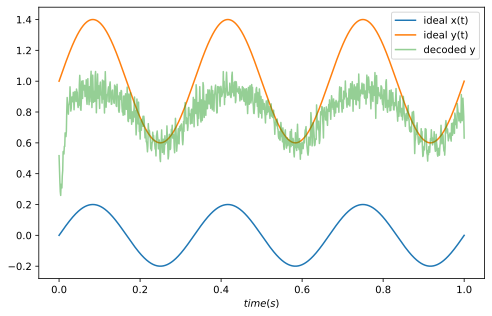

In [27]:
x3 = 0.2*np.sin(6*np.pi*t)
y3=2*x3+1

# construct population x
Neurons_X, A_X = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x3, 24)
x_hat_Df = Df@A_X

# construct population y 
Neurons_Y, A_Y = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x_hat_Df, 205)
y_hat = D_y@A_Y

plt.figure(figsize = (8,5))
plt.plot(t, x3, label='ideal x(t)')
plt.plot(t, y3, label='ideal y(t)')
plt.plot(t, y_hat, label='decoded y', alpha=0.5)

plt.title('')

plt.xlabel('$time (s) $');
plt.legend(loc='best');

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

The output does not match the ideal output well enough for c) in comparison to the previous input values a) and b). As observed in c), the decoding for values within the +/-1 range is accurate, but the decoded y does not exceed value of +/-1 when the ideal y(t) value exceeds this range. This is expected since the groups of neurons are initialized with r=1, thus any input exceeding +/-1 cannot be decoded correctly. 

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [28]:
x4 = np.cos(3*np.pi*t)
y4 = 0.5*np.sin(2*np.pi*t)

# construct population x
Neurons_X, A_X = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x4, 24)
# construct population y 
Neurons_Y, A_Y = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, y4, 205)

# decode x and y with function decoder 
fx4 = 0.5*x4
fy4 = 2*y4

D_x = functionDecoder(A_X, fx4, 0.1)
x_hat = D_x@A_X

D_y = functionDecoder(A_Y, fy4, 0.1)
y_hat = D_y@A_Y

# construct population z and input is from 
z = x_hat + y_hat
z4 = 0.5*x4 + 2*y4

Neurons_Z, A_Z = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, z, 205)
D_z = decoderWithNoise(A_Z, z, 0.1)
z_hat = D_z@A_Z

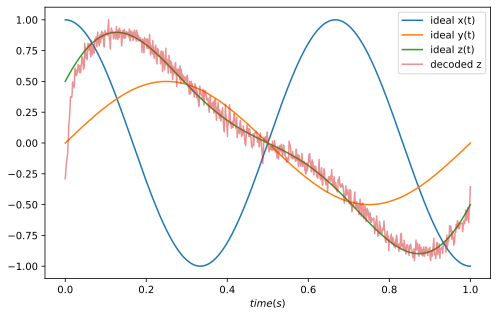

In [29]:
plt.figure(figsize = (8,5))
plt.plot(t, x4, label='ideal x(t)')
plt.plot(t, y4, label='ideal y(t)')
plt.plot(t, z4, label='ideal z(t)')
plt.plot(t, z_hat, label='decoded z', alpha=0.5)

plt.xlabel('$time (s) $');
plt.legend(loc='best');

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [30]:
x5, X5, omega = generate_signal(T, dt, 1, 8, 21)
y5, Y5, omega = generate_signal(T, dt, 0.5, 5, 42)

# construct population x
Neurons_X, A_X = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, x5, 24)
# construct population y 
Neurons_Y, A_Y = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, y5, 205)

x_hat = D_x@A_X
y_hat = D_y@A_Y

# construct population z and input is from 
z5 = 0.5*x5 + 2*y5
z = y_hat + x_hat
Neurons_Z, A_Z = generate_neuron_groups(n, T, dt, tau_rc, tau_ref, z, 205)

z_hat = D_z@A_Z

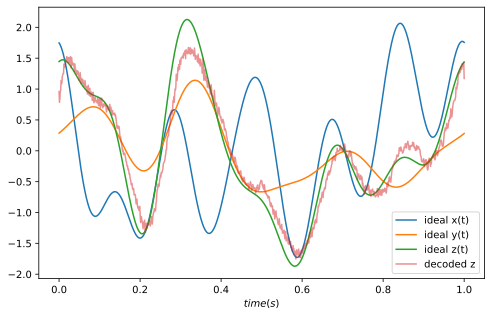

In [31]:
plt.figure(figsize = (8,5))
plt.plot(t, x5, label='ideal x(t)')
plt.plot(t, y5, label='ideal y(t)')
plt.plot(t, z5, label='ideal z(t)')
plt.plot(t, z_hat, label='decoded z', alpha=0.5)

plt.xlabel('$time (s) $');
plt.legend(loc='best');

# 6. Computing with vectors

In [32]:
def LIF_a(tau_ref, tau_rc, J):
    A = np.zeros(J.shape)
    for x, j in enumerate(J): 
        A[x] = (tau_ref - (tau_rc*np.log(1-j**(-1))))**(-1) if (j > 1) else 0
    return A

class singleNeuron2D():
    T = 0
    dt = 0.001
    encoders = 0
    x = np.linspace(0,1,int(1/dt))
    y = np.linspace(0,1,int(1/dt))
    time = 0
    X = 0
    
    # LIF params 
    alpha = 0
    j_bias = 0
    J = 0
    a = 0
    V = 0
    dV = 0
    tau_rc = 0
    tau_ref = 0
    spikes = 0
    a_max = 0
    x_int = np.matrix([0,0])
    
    def __init__(self, T, dt, tau_rc, tau_ref, encoders=None, maxFR = None, r=None):
        if encoders: 
            self.encoders = encoders
        else: 
            th = np.random.uniform(-np.pi, np.pi)
            ex = np.cos(th)
            ey = np.sin(th)
            self.encoders = np.matrix([ex, ey])
        
        # initialize lif neuron params 
        self.T = T
        self.dt = dt
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.time = np.linspace(0, T, int(T/dt))
        if r: 
            self.x = np.linspace(-r, r, int(T/dt))
            self.y = np.linspace(-r, r, int(T/dt))
            self.x_int = [np.random.uniform(low=-r, high=r), np.random.uniform(low=-r, high=r)] 
        else: 
            self.x = np.linspace(-1, 1, int(T/dt))
            self.y = np.linspace(-1, 1, int(T/dt))
            self.x_int = [np.random.uniform(low=-1, high=1), np.random.uniform(low=-1, high=1)]
        
        # initialize max firing rate
        if maxFR: 
            self.a_max = maxFR
        else: 
            self.a_max = np.random.uniform(low=100, high=200)
        
        # solve for gain a: 
        demon_p1 = 1 - np.exp((self.a_max*tau_ref - 1)/(self.a_max*tau_rc))
        demon_p2 = 1 - np.linalg.norm(self.x_int)
        self.alpha = 1/(demon_p1*demon_p2) 
        
        # solve for j_bias 
        self.j_bias = -self.alpha * np.linalg.norm(self.x_int)
        
        # set J 
        self.J = self.calcJ(self.x, self.y)
        
        # Calculate the firing rate as a function of current
        self.a = LIF_a(tau_ref, tau_rc, self.J)
    
    def calcJ(self, x, y):
        x_2d = np.matrix([x,y])
        J = self.alpha * self.encoders@x_2d + self.j_bias
        return J.T

    def spikeTrain(self, x):
        n = int(self.T/self.dt)
        
        if isinstance(x, int):
            # if input signal is constant, fill with same value 
            j = np.full([n], self.calcJ(x[0], x[1])) 
        else:
            j = self.calcJ(x[0], x[1]) 
        
        # initialize Spikes, Voltage and dV functions
        self.V = np.zeros(n)
        self.spikes = np.zeros(n)
        self.dV = np.zeros(n)
        # Calculate dV and V for each time step 
        for i in range(0,n):
             # calculate dV (change in V) given the previous V 
            self.dV[i] = 1/self.tau_rc * (j[i] - self.V[i]) * self.dt  
            if i < len(self.V)-1: 
                 # calculate next V given dV and previous V
                self.V[i+1] = self.V[i] + self.dV[i]
                # if the next V will be over 1, we spike and set V to 0
                if self.V[i+1] >= 1:                                          
                    self.V[i+1] = 0
                    self.spikes[i] = 1   
        return self.spikes

In [33]:
def spikesPostSynapticFilter(T, dt, tau, x, spikes):
    Nt = x.shape[1]
    dt = 0.001
    t = np.arange(Nt) * dt 
    # Create the filter 
    h = np.exp(-t/tau) / tau
    H = np.fft.rfft(h)
    
    SPIKES = np.fft.rfft(spikes)
    # apply filter on frequency domain signal 
    FSPIKES = H*SPIKES
    spikes_filt = np.fft.irfft(FSPIKES)
    return spikes_filt

In [34]:
def generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, x, seed): 
    A = np.zeros([n,x.shape[1]])
    Neurons = [None]*n
    
    np.random.seed(seed)
    for i in range(0, n):
        neu = singleNeuron2D(T, dt, tau_rc, tau_ref)
        Neurons[i] = neu
        spikes = neu.spikeTrain(x=x)
        spikes_filt = spikesPostSynapticFilter(T, dt, tau, x, spikes)
        A[i] = np.array(spikes_filt)
    
    return Neurons, A

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [35]:
# set signals, constant over time
t = np.linspace(0,T, int(T/dt))
n = 200

x6 = np.zeros([2, int(T/dt)])
y6 = np.zeros([2, int(T/dt)])
z6 = np.zeros([2, int(T/dt)])
q6 = np.zeros([2, int(T/dt)])

x6[0:] = 0.5
x6[1:] = 1
y6[0:] = 0.1
y6[1:] = 0.3
z6[0:] = 0.2
z6[1:] = 0.1
q6[0:] = 0.4
q6[1:]= -0.2

# construct population x
Neurons_X, A_X = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, x6, 24)
# construct population y 
Neurons_Y, A_Y = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, y6, 205)
# construct population z
Neurons_Z, A_Z = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, z6, 125)
# construct population q 
Neurons_Q, A_Q = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, q6, 523)

# decode x, y, z, q with function decoder 
fx6 = 1*x6
fy6 = -3*y6
fz6 = 2*z6
fq6 = -2*q6

D_x = functionDecoder(A_X, fx6, 0.1)
x_hat = D_x@A_X

D_y = functionDecoder(A_Y, fy6, 0.1)
y_hat = D_y@A_Y

D_z = functionDecoder(A_Z, fz6, 0.1)
z_hat = D_z@A_Z

D_q = functionDecoder(A_Q, fq6, 0.1)
q_hat = D_q@A_Q

# construct population z and input is from 
w = x_hat + y_hat + z_hat + q_hat

# ideal w6 
w6 = x6 - 3*y6 + 2*z6 - 2*q6

Neurons_W, A_W = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, w, 621)
D_w = decoderWithNoise(A_W, w, 0.1)
w_hat = D_w@A_W

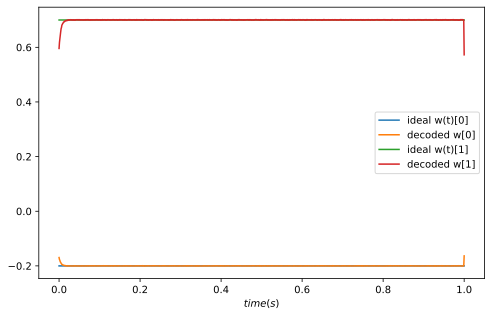

In [36]:
plt.figure(figsize = (8,5))
plt.plot(t, w6[0], label='ideal w(t)[0]')
plt.plot(t, w_hat[0], label='decoded w[0]')
plt.plot(t, w6[1], label='ideal w(t)[1]')
plt.plot(t, w_hat[1], label='decoded w[1]')

plt.xlabel('$time (s) $');
plt.legend(loc='best');

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [37]:
# set signals, constant over time
x7 = np.zeros([2, int(T/dt)])
y7 = np.zeros([2, int(T/dt)])
z7 = np.zeros([2, int(T/dt)])
q7 = np.zeros([2, int(T/dt)])

x7[0:] = 0.5
x7[1:] = 1
y7[0:] = np.sin(4*np.pi*t)
y7[1:] = 0.3
z7[0:] = 0.2
z7[1:] = 0.1
q7[0:] = np.sin(4*np.pi*t)
q7[1:]= -0.2

# construct population x
Neurons_X, A_X = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, x7, 24)
# construct population y 
Neurons_Y, A_Y = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, y7, 205)
# construct population z
Neurons_Z, A_Z = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, z7, 125)
# construct population q 
Neurons_Q, A_Q = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, q7, 523)

x_hat = D_x@A_X
y_hat = D_y@A_Y
z_hat = D_z@A_Z
q_hat = D_q@A_Q

# construct population z and input is from 
w = x_hat + y_hat + z_hat + q_hat
w7 = x7 - 3*y7 + 2*z7 - 2*q7

Neurons_W, A_W = generate_neuron_groups_2D(n, T, dt, tau_rc, tau_ref, w, 621)

w_hat = D_w@A_W

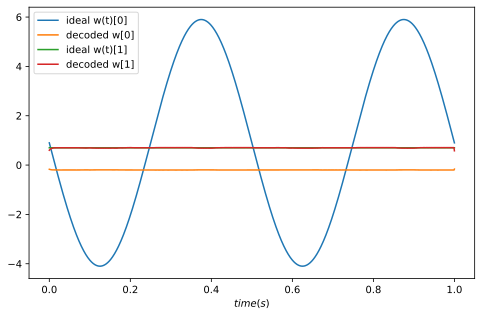

In [38]:
plt.figure(figsize = (8,5))
plt.plot(t, w7[0], label='ideal w(t)[0]')
plt.plot(t, w_hat[0], label='decoded w[0]')
plt.plot(t, w7[1], label='ideal w(t)[1]')
plt.plot(t, w_hat[1], label='decoded w[1]')

plt.xlabel('$time (s) $');
plt.legend(loc='best');

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

The decoding works well when the value is constant and does not oscillate much (as shown in b) w[1] and a) for both w[0] and w[1]). The decoding does not perform well when the input is oscillatory and exceeds +/-1. This is because the neuron population r is in this range, and that since function for input w adds the sine waves together and has some shifts, there are chances that the input may cancel each other out.  